### Wave Equation

Problem setting: one-dimensional waves on a string of length L

$$
\begin{equation}
  \frac{d^2u}{dt^2} = c^2\frac{d^2u}{dx^2}   x\in(0,L), t\in(0,T]
\end{equation}
$$

with two initial conditions:

1. the initial shape of the string

    \begin{equation}
    u(x,0) = I(x)
    \end{equation}

2. reflecting that the initial velocity of the string is zero
\begin{equation}
\frac{d}{dt}u(x,0) = 0
\end{equation}

and boundary conditions:
\begin{equation}
u(0,t) = 0
\end{equation}

\begin{equation}
u(L,t) = 0
\end{equation}


The constant c and the function I(x) must be prescribed

Concrete example

\begin{equation}
u(x,0) = A \sin(\frac{\pi}{L} x)
\end{equation}

\begin{equation}
u_e(0,t) = u_e(L,t) = 0
\end{equation}


analytic solution is

\begin{equation}
u_e(x,y,t) = A \sin(\frac{\pi}{L} x)\cos(\frac{\pi}{L} ct) 
\end{equation}



In [1]:
import numpy as np
def initial(A, x):
    return A * np.sin((np.pi/L)*x)

def analytic(A,x,c, t):
    return A * np.sin((np.pi/L)*x)*np.cos((np.pi/L)*c*t)

A = 1.
L = 1
c = 1
x = np.linspace(0,1,100)
y0 = initial(A, x)
y = analytic(A, x, c, 1)

In [11]:
!pip install devito

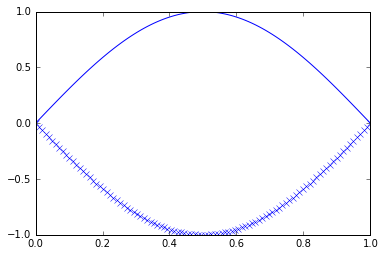

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(x,y0,'b')
plt.plot(x,y, 'x')

In [3]:
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/ngcm/training-public/master/ipython_notebook_styles/ngcmstyle.css'
HTML(url=css_file)

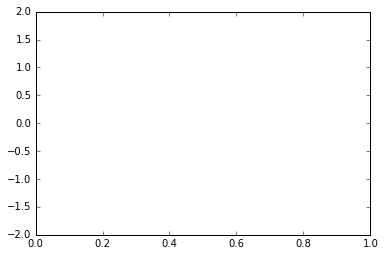

In [4]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-2,2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    c = 1
    x = np.linspace(0, 1, 500)
    #t = i/100.
    y =  A * np.sin((np.pi/L)*x)*np.cos((np.pi/L)*c*i)
    line.set_data(x, y)
    return line,


In [5]:
HTML(animation.FuncAnimation(fig, animate, init_func=init, interval=200, frames=50, blit=True).to_html5_video())

Discretization
\begin{equation}
\frac{u_i^{n+1} - 2 u_i^n + u_i^{n-1}}{\delta t^2} = c^2 \frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\delta x^2} 
\end{equation}

$$
\begin{equation}
u_i^{n+1} = 2 u_i^n - u_i^{n-1} + C^2  (u_{i+1}^n - 2u_i^n + u_{i-1}^n)
\end{equation}
$$

\begin{equation}
C = c \frac{\delta t}{\delta x}
\end{equation}

In [6]:
Nt = 100
Nx = 100
x, dx = np.linspace(0, 1, Nx, retstep=True)
t, dt = np.linspace(0,1, Nt, retstep=True)
c=1
C = c *dt/dx


In [12]:
from devito import TimeData, Operator
from sympy import Eq, solve
from sympy.abc import h, s

Nt = 150
L = 1
dx = 0.01
x = np.arange(0, L ,dx)
dt = 1e-9
c=1

#initial condition
u0 = initial(A, x)

#first step, du/dt = 0 ---> u_i_n-1 & u_i_n+1 are equal, v=0
u1 = np.zeros_like(u0)
u1[1:-1] = u0[1:-1] - 0.5* C**2 * (u0[2:] -2*u0[1:-1]+u0[0:-2])
#enforce BC
u1[0] = 0; u1[L] = 0

nx = len(x)
# Allocate the grid and set initial condition
# Note: This should be made simpler through the use of defaults
u = TimeData(name='u', shape=(nx, ), time_order=2, space_order=2)
u.data[0, :] = u0[:]
u.data[1, :] = u1[:]


In [13]:
# Derive the stencil according to devito conventions
eqn = Eq(u.dt, c * u.dx2)
stencil = solve(eqn, u.forward)[0]
op = Operator(Eq(u.forward, stencil), subs={h: dx, s: dt})

# Execute the generated Devito stencil operator
op.apply(u, t=Nt)

DSE: <filter object at 0x1136a4358> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x1136a4518> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x1136a4358> [flops: 7, elapsed: 0.00] >>
     <filter object at 0x1136a4518> [flops: 6, elapsed: 0.01] >>
     <filter object at 0x1136a4358> [flops: 6, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: <filter object at 0x1136cb940> [elapsed: 0.00] >>
     <filter object at 0x1136cb940> [elapsed: 0.00] >>
     <filter object at 0x1136cb940> [elapsed: 0.00] >>
     <filter object at 0x1136cb940> [elapsed: 0.00] >>
     <filter object at 0x1136cb940> [elapsed: 0.00] >>
     <filter object at 0x1136cb908> [elapsed: 0.00]
     [Total elapsed: 0.02 s]
FAILED compiler invocation: gcc -O3 -g -march=native -fPIC -Wall -std=c99 -shared /var/folders/f3/c2wg4lkx1ms7_41c3qzz8x7nrdhbjw/T/devito-1893215804/f25a8ccfabc27c50338e2e672fd9c46de667fb3f.c -o /var/folders/f3/c2wg4lkx1ms7_41c3qzz8x7nrdhbjw/T/devito-1893215804/f25a8ccfabc27c50338e2e672fd9c46

CompileError: module compilation failed

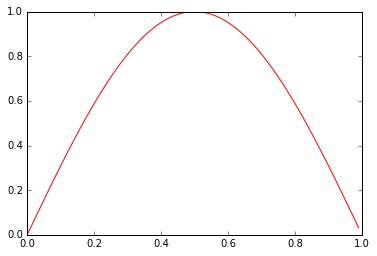

In [10]:
plt.plot(x,u0, '-r')
plt.plot(x,u.data[2,:], '-g')